# <center> Multi-Class Classification </center>
<center> Corinne Jones, TA </center>
<center> DATA 558, Spring 2020 </center>

## 1 Introduction
As discussed in class, there are a variety of ways you can perform multi-class classification. This lab will show you how you use these methods in Scikit-learn. By the end of the lab, you should:
- Be able to describe the differences between one-vs-one, one-vs-rest, and multi-class classification 
- Understand how to perform one-vs-rest classification yourself
- Know various error metrics for multi-class classification

## 2 Multi-class methods
There are a variety of ways of performing classification when there are are $k>2$ classes. These options include:
- Multi-class classification: For some algorithms (like logistic regression and SVM), researchers have developed generalizations to the multi-class case.
- Binary one-vs-one classification: In this case, we fit models for all ${k\choose 2}$ possible pairs of classes. For instance, in one of these models we will label the data in class 0 as +1 and the data in class 1 as -1 and fit a model with the data from these two classes. For prediction, you predict the class of the new point using all ${k\choose 2}$ classifiers and record which classes it assigns it to. The class it is assigned to most frequently is then our prediction.
- Binary one-vs-rest classification: In this case, we fit $k$ models. In each model, data from one of the classes is labeled as +1 and the data from the other classes are labeled -1. For prediction on a new data point, we compute the output of each model on the data point (This output must be continuous). Suppose the model for which the output yields the highest value assigns the label +1 to class $i$. Then we predict that the new point is from class $i$.

Let's see how we can use perform multi-class classification in Scikit-learn.

### 2.1 Multinomial Logistic Regression on the Digits dataset
In this lab we'll look at how to perform multi-class classification on the Digits dataset. Digits is a dataset consisting of images of handwritten digits. Some of the code below comes from http://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html

Size of each image: (8, 8)


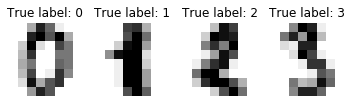

In [1]:
# Standard scientific Python imports
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np

# Import datasets, classifiers and performance metrics
import sklearn
from sklearn import datasets, linear_model, multiclass, preprocessing
from sklearn.model_selection import GridSearchCV

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits. Let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(1, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('True label: %i' % label)

print('Size of each image:', image.shape)

Recall that in multinomial logistic regression with $k$ classes we have that for classes $j=1,\dots, k-1$
$$ P(y=j|X=x) = \frac{\exp(\beta_{j,0}+\beta_j^Tx)}{1+\sum_{m=1}^{k-1}\exp(\beta_{m,0} +\beta_m^Tx)} $$
and for class $k$ we have 
$$ P(y=k|X=x) = \frac{1}{1+\sum_{m=1}^{k-1}\exp(\beta_{m,0} +\beta_m^Tx)}. $$

Now we'll split the data into training and test sets, since these splits aren't provided.

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(digits.images.reshape(-1, 64), digits.target, random_state=0)

In [8]:
print('Shape of training data:', x_train.shape)
print('Shape of test data:', x_test.shape)

Shape of training data: (1347, 64)
Shape of test data: (450, 64)


**Exercise 1.** Use `LogisticRegressionCV` to fit a multinomial logistic regression model on the training set. Then predict the accuracy on the test set.

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [13]:
from sklearn.linear_model import LogisticRegressionCV
mnl = LogisticRegressionCV(multi_class='multinomial', max_iter=500, n_jobs=-1)
mnl.fit(x_train, y_train)

yhat_test_mnl = mnl.predict(x_test)
mnl.score(x_test, y_test)

0.9644444444444444

**Exercise 2.** Try using the one-vs-rest option instead. How does the accuracy on the test set compare?

In [14]:
ovr = LogisticRegressionCV(multi_class='ovr', max_iter=500, n_jobs=-1)
ovr.fit(x_train, y_train)

ovr.score(x_test, y_test)

0.9666666666666667

**Exercise 3.** Now try one-vs-one using `OneVsOneClassifier` (http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html#sklearn.multiclass.OneVsOneClassifier). How does this accuracy compare to those above?

In [15]:
lrcv = LogisticRegressionCV()
ovo = sklearn.multiclass.OneVsOneClassifier(lrcv, n_jobs=-1)

ovo.fit(x_train, y_train)
ovo.score(x_test, y_test)

0.9644444444444444

### 2.2 Do-it-yourself one-vs-rest with binary logistic loss
In this section we'll see how to perform one-vs-rest with logistic regression. Since you have already coded $l_2^2$-regularized logistic regression for homework, we'll just use scikit-learn's logistic regression function here. Recall that coding one-vs-rest ourselves requires fitting $k$ classifiers, where $k$ is the number of classes. Also note that when the training set is imbalanced, reweighting the data can sometimes be helpful. You can specify weights with the class_weight option in LogisticRegressionCV.

**Exercise 4.** Fill in the code below to perform one-vs-rest classification using the binary logistic loss.

In [23]:
k = np.max(y_train) + 1  # Number of classes
n_test = np.size(x_test, 0)  # Number of examples in the test set
est_probs = np.zeros((n_test, k))  # Matrix where we'll store the estimated probabilities
lrcv = LogisticRegressionCV(max_iter=500)

for i in range(k):
    # To do: Convert labels to indicate whether the observation is from class i
    y_i = (y_train == i)
    # To do: Fit a logistic regression model on class i vs. the other classes
    lrcv.fit(x_train, y_i)
    # To do: Get and store the estimated probability that each obs is in class i using the predict_proba() method
    est_probs[:, i] = lrcv.predict_proba(x_test)[:, 1]

# Find the most likely class for each test example
predictions = np.argmax(est_probs, axis=1)

# Compute the accuracy
accuracy = np.mean(predictions == y_test)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 96.67%


In [18]:
y_train

array([2, 8, 9, ..., 7, 7, 8])

In [19]:
(y_train == 8)

array([False,  True, False, ..., False, False,  True])

In [21]:
y_i = (y_train == 0)
lrcv.fit(x_train, y_i)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [22]:
lrcv.predict_proba(x_test)

array([[9.99999981e-01, 1.85901236e-08],
       [1.00000000e+00, 1.32646333e-10],
       [1.00000000e+00, 2.63006798e-14],
       [9.99999673e-01, 3.27099163e-07],
       [9.99815981e-01, 1.84019486e-04],
       [9.99999993e-01, 6.56959625e-09],
       [1.00000000e+00, 4.46194630e-13],
       [9.99971211e-01, 2.87889046e-05],
       [9.99999999e-01, 7.18194219e-10],
       [9.99975138e-01, 2.48624059e-05],
       [1.00000000e+00, 1.05140908e-14],
       [9.99989595e-01, 1.04046764e-05],
       [9.99996931e-01, 3.06900290e-06],
       [9.99998509e-01, 1.49084572e-06],
       [9.99999998e-01, 1.65673929e-09],
       [9.99999986e-01, 1.36149782e-08],
       [1.00000000e+00, 1.34006682e-12],
       [6.96181921e-07, 9.99999304e-01],
       [1.00000000e+00, 8.26207111e-11],
       [9.99999870e-01, 1.29820162e-07],
       [9.99998739e-01, 1.26067607e-06],
       [9.99925405e-01, 7.45946079e-05],
       [9.99999997e-01, 3.30145276e-09],
       [9.96596355e-01, 3.40364477e-03],
       [1.000000

### 2.3 Error metrics
There are various ways to assess the quality of predictions from multi-class classification. These include:
- Confusion matrix: A matrix whose $(i,j)$th entry represents the number of observations that are known to be in class i but were assigned to class j
- Misclassification error: The fraction of observations that are misclassified
- Top-1 accuracy: The fraction of observations for which the top prediction for that observation is correct
- Top-k accuracy: The fraction of observations for which the true label is in the top k predictions

**Exercise 5.** Suppose you have 5 observations $x_1, x_2, x_3, x_4, x_5$ total across three classes, A, B, and C. Your classifier told you the following:
- $P(A|x_1) > P(C|x_1) > P(B|x_1)$
- $P(C|x_2) > P(A|x_2) > P(B|x_2)$
- $P(A|x_3) > P(C|x_3) > P(B|x_3)$
- $P(B|x_4) > P(C|x_4) > P(A|x_4)$
- $P(A|x_5) > P(B|x_5) > P(C|x_5)$ 

In reality, $x_1$ and $x_2$ were from class A, $x_3$ and $x_4$ were from class B, and $x_5$ was from class C. Compute the following:
1. Confusion matrix
2. Misclassification error
3. Top-1 accuracy
4. Top-2 accuracy

Let's look at these on the results from the multinomial logistic regression example above.

**Exercise 6.** Compute the confusion matrix for the multinomial logistic example in Section 2.1. Reference: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, yhat_test_mnl)

array([[37,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 40,  0,  0,  0,  0,  1,  0,  1,  1],
       [ 0,  0, 44,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 44,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0, 36,  0,  0,  2,  0,  0],
       [ 0,  0,  0,  0,  0, 46,  0,  0,  0,  2],
       [ 0,  1,  0,  0,  0,  0, 51,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0, 47,  0,  0],
       [ 0,  3,  1,  0,  0,  0,  0,  0, 44,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  1,  0, 45]])

In the above confusion matrix, the rows represent the truth, while the columns represent the predictions. We can see that most of the time the classifier is correct. 

Now let's look at the other performance measures.

**Exercise 7.** Compute the top-1 accuracy and misclassification error for the multinomial logistic example in Section 2.1.

In [27]:
accuracy = np.mean(y_test == yhat_test_mnl)
accuracy

0.9644444444444444

In [29]:
misclassification_error = 1-accuracy
misclassification_error

0.03555555555555556

**Exercise 8.** Compute top-2 accuracy for the misclassification error for the multinomial logistic example in Section 2.1. Scikit-learn doesn't appear to have a built-in function to compute it, so compute it "by hand".

In [30]:
probs = mnl.predict_proba(x_test)
n = len(x_test)
top2_accuracy = 0
for i in range(n):
    top2 = np.argsort(probs[i, :])[-2:]
    if y_test[i] in top2:
        top2_accuracy += 1

top2_accuracy /= n
print(top2_accuracy)

0.9888888888888889


### 2.4 Imbalanced classes
When the number of observations in one class is much different than the number of observations in the other class(es), it is often beneficial to reweight the data. Suppose the labels $y_i$ are $\pm 1$. Then we can write the usual objective function as 

$$ \frac{1}{n} \sum_{i=1}^n L(x_i, y_i; \beta) = \frac{1}{n} \sum_{i:y_i=+1} L(x_i, y_i; \beta) + \frac{1}{n} \sum_{i:y_i=-1} L(x_i, y_i; \beta). $$

From this, we can see that if, e.g., there are many more observations with $y_i=-1$ than with $y_i=+1$, then the negative observations are weighted more heavily than the positive observations. If we want to weight the positive and negative classes equally, we can take as our objective function

$$ \frac{1/2}{n_+} \sum_{i:y_i=+1} L(x_i, y_i; \beta) + \frac{1/2}{n_-} \sum_{i:y_i=-1} L(x_i, y_i; \beta), $$ 
where $n_+=\left\vert\{ i:y_i=+1\}\right\vert$ (the number of observations with $y_i=+1$) and $n_-=\left\vert\{ i:y_i=-1\}\right\vert$ (the number of observations with $y_i=-1$). Even better, we can optimize over a class imbalance parameter $\rho$:

$$ \frac{\rho}{n_+} \sum_{i:y_i=+1} L(x_i, y_i; \beta) + \frac{1-\rho}{n_-} \sum_{i:y_i=-1} L(x_i, y_i; \beta). $$

When performing classification with $k$ classes, $j=1,\dots, k$, optimizing one imbalance parameter per class is too computationally demanding, so we typically just weight each class equally:

$$ \frac{1}{k}\sum_{j=1}^k \frac{1}{n_j} \sum_{i:y_i=j} L(x_i, y_i; \beta), $$
where $n_j=\left\vert\{ i:y_i=j\}\right\vert$.

**Exercise 9.** Redo exercise 2 using the `class_weight=balanced` option. Does the performance of the classifier improve?

In [31]:
ovr = LogisticRegressionCV(multi_class='ovr', max_iter=500, n_jobs=-1, class_weight='balanced')
ovr.fit(x_train, y_train)

ovr.score(x_test, y_test)

0.9622222222222222